In [36]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from collections import Counter, defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import models


import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE


from skimage.feature import hog
from skimage import color
import xgboost as xgb
import optuna

from statistics import mean
import ast

# Fonction exploration data

## Fonction info en csv

In [2]:
def info_data(txt_folder):
    data = []
    for txt_file in os.listdir(txt_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(txt_folder, txt_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    avis = parts[0]
                    xc = parts[-4]
                    yc = parts[-3]
                    w = parts[-2]
                    h = parts[-1]
                    other = parts[1:-4]
                    file_id = txt_file.replace('.txt', '')
                    data.append([file_id, avis] + [xc, yc, w, h] + other)
    columns = ['id', 'avis'] + ['xc', 'yc', 'w', 'h'] + ['classe','year'] + [f'info{i+2}' for i in range(4)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('info_data.csv', index=False)
info_data('data')

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('info_data.csv')
df.head(5)

,id,avis,xc,yc,w,h,classe,year,info2,info3,info4,info5
0,0.00103249727675203130.23677820798415050.70508...,0_0_0_0,0.167480,0.226318,0.329102,0.418457,VADEBIO,2010,NaN,NaN,NaN,NaN
1,0.0019854243295879260.0286276958653508550.8295...,0_0_0_0,0.627279,0.388428,0.188802,0.734863,Pompey_1,2007,NaN,NaN,NaN,NaN
2,0.0055826482360382680.53755056558076890.187769...,0_0_0_0,0.565430,0.305420,0.113932,0.324707,Pompey_1,2007,NaN,NaN,NaN,NaN
3,0.0056082525335631180.072100167826147480.09500...,4_4_4_4,0.414062,0.298096,0.149740,0.402832,Bioindicateur,2,2009/2010,NaN,NaN,NaN
4,0.0056082525335631180.072100167826147480.09500...,0_0_0_0,0.595540,0.625244,0.493164,0.441895,Bioindicateur,2,2009/2010,NaN,NaN,NaN


In [ ]:
len(df['id'].unique())

1117

## Afficher box

In [14]:
df = pd.read_csv('info_data.csv')

In [25]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def show_boxes(image_id, df, afficher_image=False, afficher_carre=False, save_images=False):
    image_path = f"./data/{image_id}.jpg"
    image = Image.open(image_path)
    img_width, img_height = image.size
    
    draw = ImageDraw.Draw(image)
    df_image = df[df['id'] == image_id]
    
    for _, row in df_image.iterrows():
        xc, yc, w, h = row['xc'], row['yc'], row['w'], row['h']
        x1 = float((xc - w / 2) * img_width)
        y1 = float((yc - h / 2) * img_height)
        x2 = float((xc + w / 2) * img_width)
        y2 = float((yc + h / 2) * img_height)
        draw.rectangle([x1, y1, x2, y2], outline="green", width=10)
        
        print(f"Bounding Box: ({x1}, {y1}), ({x2}, {y2})")
    
    new_x1, new_y1 = 50, 50 
    new_x2, new_y2 = new_x1 + 822, new_y1 + 822
    
    # Vérifier que le carré reste dans les limites de l'image
    if new_x2 > img_width:
        new_x1 = img_width - 822
        new_x2 = img_width
    if new_y2 > img_height:
        new_y1 = img_height - 822
        new_y2 = img_height
    
    draw.rectangle([new_x1, new_y1, new_x2, new_y2], outline="red", width=10)
    print(f"Carré 822x822: ({new_x1}, {new_y1}), ({new_x2}, {new_y2})")
    
    # Sauvegarde de l'image avec les bounding boxes
    if save_images:
        image.save(f"./image/{image_id}_with_boxes.jpg")
    
    if afficher_image:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    
    # Affichage et sauvegarde de l'image de la deuxième bounding box
    image_carre = image.crop((new_x1, new_y1, new_x2, new_y2))
    if save_images:
        image_carre.save(f"./image/{image_id}_cropped_box.jpg")
    
    if afficher_carre:
        plt.imshow(image_carre)
        plt.axis('off')
        plt.show()

Bounding Box: (527.0, 1153.0), (1497.0, 2047.0)
Carré 822x822: (50, 50), (872, 872)


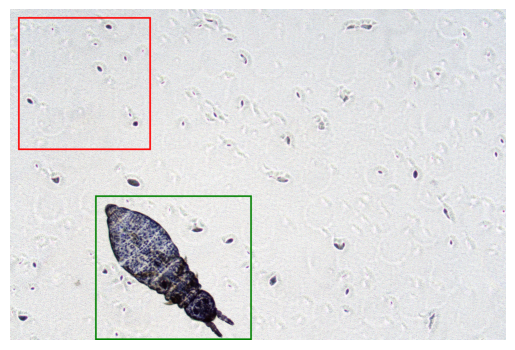

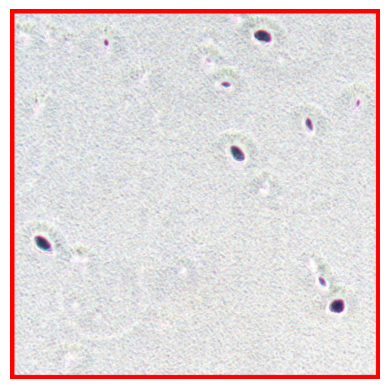

In [26]:
show_boxes('0.24464457081350.88336921705746710.18602568807154019', df, afficher_image=True, afficher_carre=True, save_images=True)

## Taille moyenne box

In [143]:
def calculate_average_box_size_in_pixels(csv_file, images_dir):
    data = pd.read_csv(csv_file)
    
    total_width = 0
    total_height = 0
    num_boxes = len(data)
    
    for _, row in data.iterrows():
        image_id = str(row['id'])
        w = row['w']
        h = row['h']
        
        image_path = os.path.join(images_dir, f"{image_id}.jpg")
        image = Image.open(image_path)
        img_width, img_height = image.size
        
        box_width = w * img_width
        box_height = h * img_height
        
        total_width += box_width
        total_height += box_height
    
    average_width = total_width / num_boxes
    average_height = total_height / num_boxes
    
    print(f"Taille moyenne des boîtes (en pixels) : ({average_width:.2f}, {average_height:.2f})")
    return average_width, average_height
calculate_average_box_size_in_pixels('./info_data.csv', 'data')

Taille moyenne des boîtes (en pixels) : (823.73, 822.54)


(823.7328080229227, 822.5429799426934)

## Choix de la classe

In [ ]:
def avis_majoritaire(liste):
    for avis in liste:
        parts = avis.split('_')
        for part in parts:
            count = Counter(part)
            majority_part = min(count, key=lambda x: (-count[x], x))   
        print(majority_part)
    
#avis_majoritaire(df['avis'])

## Test des fonctions

In [41]:
def avis_majoritaire(avis, min_count=4):
    """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
    parts = avis.split('_')
    count = Counter(parts)

    # Trouver l'avis le plus fréquent et son nombre d'occurrences
    majoritaire, occurrences = max(count.items(), key=lambda x: x[1])

    # Vérifier si le nombre d'occurrences dépasse le seuil
    if occurrences >= min_count:
        return int(majoritaire)

    return None
avis_majoritaire('1_1_1_2')

# Dataset 

## Classe pour background

In [13]:
import numpy as np
import random
import torch
from torchvision import transforms

class BackgroundDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, num_samples=1000):
        """
        Dataset qui génère des images de fond (classe 8) en évitant les bounding boxes existantes.

        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            num_samples (int): Nombre de samples de background à générer.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.num_samples = num_samples

        # Charger les informations du dataset original
        self.data = pd.read_csv(csv_file)
        self.boxes = self._load_boxes()
        self.image_ids = list(self.boxes.keys())  # Liste des images disponibles

    def _load_boxes(self):
        """
        Charge toutes les bounding boxes sous forme de dictionnaire {image_id: [bbox_list]}.
        """
        boxes = {}
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            if image_id not in boxes:
                boxes[image_id] = []
            boxes[image_id].append(bbox)
        return boxes

    def _get_random_background_patch(self, image, bboxes):
        """
        Extrait une zone aléatoire de l'image en évitant les bounding boxes existantes.
        """
        width, height = image.size
        patch_size = 822  # Taille fixe du patch

        for _ in range(10):  # Essayer 10 fois de trouver une zone correcte
            x = random.randint(0, width - patch_size)
            y = random.randint(0, height - patch_size)

            # Vérifier si la zone chevauche une bounding box
            overlaps = False
            for (xc, yc, w, h) in bboxes:
                x_min = int((xc - w / 2) * width)
                x_max = int((xc + w / 2) * width)
                y_min = int((yc - h / 2) * height)
                y_max = int((yc + h / 2) * height)

                if not (x_max < x or x_min > x + patch_size or y_max < y or y_min > y + patch_size):
                    overlaps = True
                    break
            
            if not overlaps:
                return image.crop((x, y, x + patch_size, y + patch_size))

        # Si aucune zone correcte n'a été trouvée après 10 essais, prendre une zone au hasard
        return image.crop((0, 0, patch_size, patch_size))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Retourne un patch de fond et le label 8.
        """
        image_id = random.choice(self.image_ids)
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")

        bboxes = self.boxes[image_id]
        background_patch = self._get_random_background_patch(image, bboxes)

        if self.transform:
            background_patch = self.transform(background_patch)
            
        label = torch.tensor(8, dtype=torch.long)

        return background_patch, label


## Classe pour image

In [7]:
class ImageBoundingBoxDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        
        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self._split_data()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label not in [None, 8]:  
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'label': label
                })
        return boxes

    def _split_data(self):
        """
        Effectue le split de l'ensemble de données en train, validation et test,
        et choisit le split actif.
        """
        labels = [box["label"] for box in self.boxes]
        # Créer un split fixe basé sur l'index
        train_data, test_data = train_test_split(self.boxes, test_size=0.4, random_state=self.seed, stratify=labels)

        # Choisir le dataset basé sur le split demandé
        if self.split == "train":
            self.data_split = train_data
        elif self.split == "test":
            self.data_split = test_data
        else:
            raise ValueError("Split must be one of ['train', 'val', 'test']")

    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.data_split:
            label = annotation['label']
            class_counts[label] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=4):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)
        
        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
        
        if occurrences >= min_count:
            return int(majoritaire)
        
        return None


    def __len__(self):
        return len(self.data_split)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.data_split[idx]
        bbox = annotation['bbox']
        label = annotation['label']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)
            
        label = torch.tensor(label, dtype=torch.long)
            
        return cropped_image, label

## Image sans label

In [15]:
class ImageLabelDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        
        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label in [None]:  
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'avis': avis
                })
        return boxes


    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.boxes:
            avis = annotation['avis']
            class_counts[avis] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=4):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)
        
        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
        
        if occurrences >= min_count:
            return int(majoritaire)
        
        return None


    def __len__(self):
        return len(self.data_split)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.boxes[idx]
        bbox = annotation['bbox']
        avis = annotation['avis']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)
            
        # label = torch.tensor(label, dtype=torch.long)
            
        return cropped_image, avis

## CLasse image avec label

In [38]:
class Image_label_Dataset(Dataset):
    def __init__(self, images_dir, csv_file, fallback_csv, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations principales.
            fallback_csv (string): Chemin vers le fichier CSV contenant image_id + bbox + final_label.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        
        self.data = pd.read_csv(csv_file)
        self.fallback_data = pd.read_csv(fallback_csv)
        self.boxes = self._create_boxes_list()

        self._split_data()
        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            
            if label is None:
                label = self.get_fallback_label(image_id, bbox)
            
            if label not in [None, 8]:  
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'label': label
                })
        return boxes

    def get_fallback_label(self, image_id, bbox):
        """
        Cherche le label dans le fichier CSV de fallback si avis_majoritaire retourne None.
        """
        # Convertir la chaîne de caractères du 'bbox' du fichier fallback en tuple
        self.fallback_data['bbox_tuple'] = self.fallback_data['bbox'].apply(lambda x: ast.literal_eval(x))

        # Arrondir le bbox à 5 décimales pour correspondre au format du fichier fallback
        bbox_round = tuple(round(val, 5) for val in bbox)

        # Recherche d'une correspondance
        match = self.fallback_data[(self.fallback_data['idx'] == image_id) & 
                                    (self.fallback_data['bbox_tuple'] == bbox_round)]

        if not match.empty:
            return int(match.iloc[0]['final_label'])
        
        return None

    def _split_data(self):
        """
        Effectue le split de l'ensemble de données en train et test.
        """
        labels = [box["label"] for box in self.boxes]
        train_data, test_data = train_test_split(self.boxes, test_size=0.4, random_state=self.seed, stratify=labels)

        if self.split == "train":
            self.data_split = train_data
        elif self.split == "test":
            self.data_split = test_data
        else:
            raise ValueError("Split must be one of ['train', 'test']")

    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.data_split:
            label = annotation['label']
            class_counts[label] += 1
        return dict(class_counts)
    
    def get_all_images_and_labels(self):
        """
        Récupère toutes les images et leurs labels sans split (train/test).
        Retourne une liste de tuples (image_id, label).
        """
        return [(box['image_id'], box['label']) for box in self.boxes]


    def avis_majoritaire(self, avis, min_count=4):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)
        
        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
        
        if occurrences >= min_count:
            return int(majoritaire)
        
        return None

    def __len__(self):
        return len(self.data_split)

    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.data_split[idx]
        bbox = annotation['bbox']
        label = annotation['label']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)
            
        label = torch.tensor(label, dtype=torch.long)
            
        return cropped_image, label


## Create dataset

In [17]:
img_dir = "./data"
csv_file = "./info_data.csv"
label_csv = './predict_no_label/final_predict_logit.csv'

image_size = 512

transform = transforms.Compose([
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8032728433609009, 0.7945748567581177, 0.7861791253089905], std=[0.14696455001831055, 0.1625434011220932, 0.15391086041927338])
    ])

train_dataset = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file, fallback_csv=label_csv, transform=transform, split='train')
test_dataset = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file, fallback_csv=label_csv, transform=transform, split='test')

#train_dataset_label = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file, fallback_csv=label_csv, transform=transform, split='train')
#test_dataset_label = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file, fallback_csv=label_csv, transform=transform, split='test')

train_background = BackgroundDataset(img_dir, csv_file, transform=transform, num_samples=int(mean(train_dataset.class_counts.values())))
test_background = BackgroundDataset(img_dir, csv_file, transform=transform, num_samples=int(mean(test_dataset.class_counts.values())))

In [40]:
label_csv = './predict_no_label/final_predict_logit.csv'

In [41]:
dataset = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file, fallback_csv=label_csv, transform=transform)
all_images_labels = dataset.get_all_images_and_labels()

In [49]:
import pandas as pd
pd.DataFrame(all_images_labels, columns=['image_id', 'label'])['image_id'].iloc[0] #.to_csv('Labellisation.csv', index=False)

'0.00103249727675203130.23677820798415050.7050857562244466'

In [18]:
train_dataset.__len__() + test_dataset.__len__()

1396

On créé les datasets avec background, avec comme nombre d'image la veleur moyenne des classes

In [19]:
train_data_background = torch.utils.data.ConcatDataset([train_dataset, train_background])
test_data_background = torch.utils.data.ConcatDataset([test_dataset, test_background])

In [20]:
full_data_background = torch.utils.data.ConcatDataset([train_data_background, test_data_background])
full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

## Image sans classe

In [11]:
transform_matis = transforms.Compose([
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8032728433609009, 0.7945748567581177, 0.7861791253089905], std=[0.14696455001831055, 0.1625434011220932, 0.15391086041927338])
    ])

image_no_label = ImageLabelDataset(images_dir=img_dir, csv_file=csv_file, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


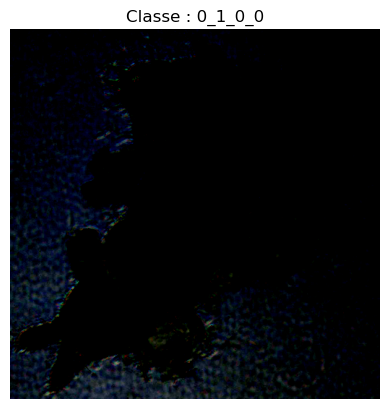

In [12]:
image, label = image_no_label[198]
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Classe : {label}")
plt.axis('off')
plt.show()

## Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


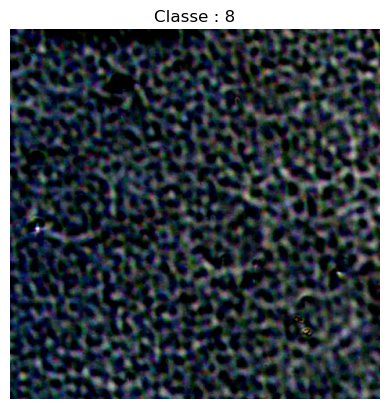

In [21]:
image, label = train_background[29]
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Classe : {label}")
plt.axis('off')
plt.show()

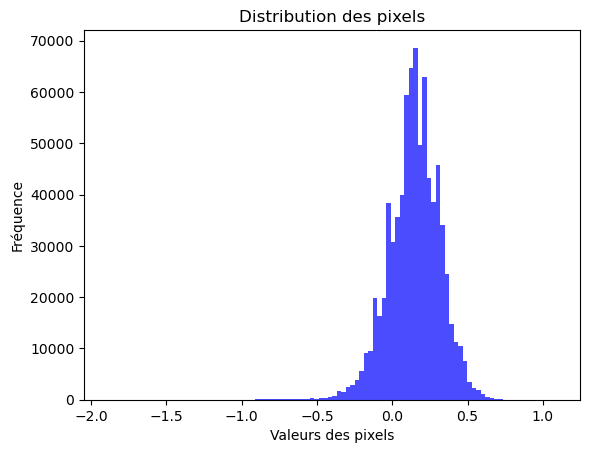

In [22]:
flattened = image.flatten()

# Calculer l'histogramme
plt.hist(flattened.numpy(), bins=100, color='blue', alpha=0.7)
plt.title("Distribution des pixels")
plt.xlabel("Valeurs des pixels")
plt.ylabel("Fréquence")
plt.show()

In [150]:
proportions = {key: train_dataset_label.class_counts[key] / test_dataset_label.class_counts[key] for key in train_dataset_label.class_counts if key in test_dataset_label.class_counts and test_dataset_label.class_counts[key] != 0}
proportions

{1: 1.5,
 2: 1.510204081632653,
 3: 1.4883720930232558,
 6: 1.4772727272727273,
 5: 1.5,
 7: 1.488888888888889,
 0: 1.4974093264248705,
 4: 1.5151515151515151}

In [ ]:
full_loader = DataLoader(full_dataset, batch_size=8, shuffle=False)

pixel_sum = torch.zeros(3) 
pixel_squared_sum = torch.zeros(3)
num_pixels = 0 

for images, _ in full_loader:
    images = images.view(images.shape[0], images.shape[1], -1) 
    pixel_sum += images.mean(dim=[0, 2])  
    pixel_squared_sum += (images ** 2).mean(dim=[0, 2])
    num_pixels += 1

mean = pixel_sum / num_pixels
std = torch.sqrt(pixel_squared_sum / num_pixels - mean ** 2)

print(f"Mean: {mean.tolist()}") 
print(f"Std: {std.tolist()}")


Mean: [0.8032728433609009, 0.7945748567581177, 0.7861791253089905]
Std: [0.14696455001831055, 0.1625434011220932, 0.15391086041927338]


# Model

## Paramètres

In [16]:
#python -m tensorboard.main --logdir=tensorboard

In [22]:
BATCH_SIZE = 8
LR = 1e-3
EPOCH = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 9

In [23]:
train_loader = DataLoader(train_data_background, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data_background, batch_size=BATCH_SIZE, shuffle=False)
full_loader = DataLoader(full_data_background, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### For tf / keras :

In [19]:
def torch_to_tf_dataset(dataloader):
    def gen():
        for images, labels in dataloader:
            yield images.numpy(), labels.numpy()

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 3, image_size, image_size), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
        )
    )
    
train_ds = torch_to_tf_dataset(train_loader)
test_ds = torch_to_tf_dataset(test_loader)
full_ds = torch_to_tf_dataset(full_loader)

### criterion weight

In [ ]:
total_instances = sum(test_dataset.count_classes_with_backgrounds().values())

class_weights = {k: total_instances / v for k, v in test_dataset.count_classes_with_backgrounds().items()}

class_weights_list = [class_weights[str(i)] if str(i) in class_weights else 0 for i in range(9)]

class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

## CNN Feature

In [21]:
writer = SummaryWriter("tensorboard/tsne_efficientnet")

model_feature = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model_feature.classifier = nn.Identity()  # Retirer la dernière couche
model_feature.eval() 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
def extract_features(dataloader, model, device):
    all_features = []
    all_labels = []
    
    model.to(device)
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = model(images)  # Extraction des features
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

In [23]:
def tsne_transform(features):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    return tsne.fit_transform(features)

In [24]:
def log_tsne(epoch, features, labels):
    tsne_result = tsne_transform(features)
    writer.add_embedding(tsne_result, metadata=labels, global_step=epoch)

In [25]:
for epoch in range(10): 
    print(f"Epoch {epoch+1}")
    features, labels = extract_features(train_loader, model_feature, DEVICE)
    log_tsne(epoch, features, labels)

writer.close()


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


KeyboardInterrupt: 

## HOG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


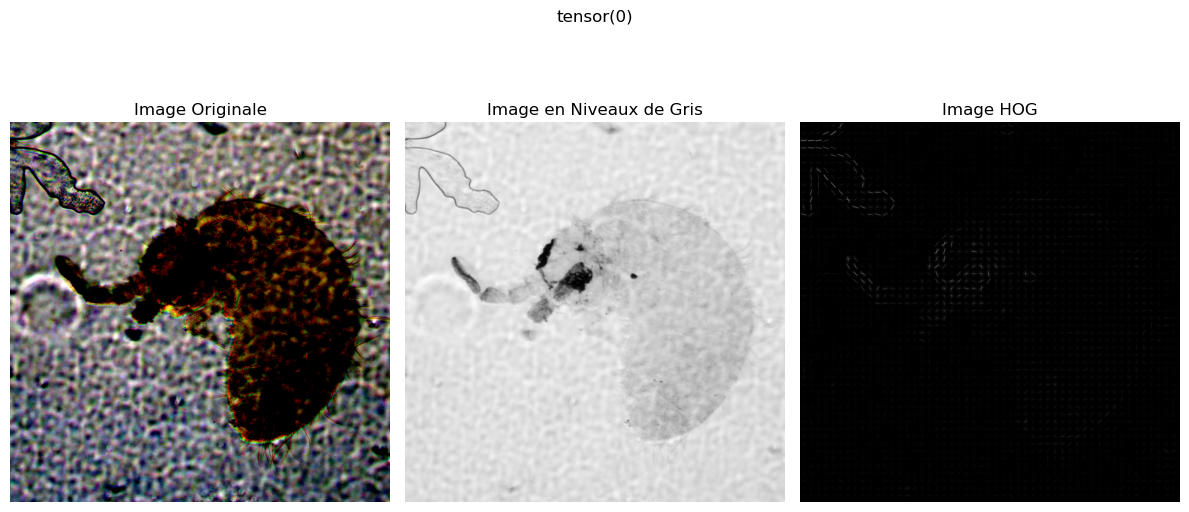

In [83]:
def visualize_hog_from_dataloader(data_loader):
    # 1. Récupérer un batch d'images
    images, labels = next(iter(data_loader))  # Obtenir un batch
    image = images.cpu().numpy()  # Prendre la première image du batch

    # 2. Convertir l'image au format numpy (si nécessaire)
    image = np.transpose(image[4], (1, 2, 0))  # Passer de (C, H, W) à (H, W, C)
    
    # 3. Convertir en niveaux de gris
    gray_image = color.rgb2gray(image)

    # 4. Appliquer HOG
    hog_features, hog_image = hog(
        gray_image, 
        orientations=12, 
        pixels_per_cell=(16, 16), 
        cells_per_block=(3, 3), 
        block_norm='L2-Hys', 
        visualize=True
    )

    # 5. Visualiser l'image originale, en niveaux de gris et HOG
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title("Image Originale")
    ax[0].axis('off')

    ax[1].imshow(gray_image, cmap=plt.cm.gray)
    ax[1].set_title("Image en Niveaux de Gris")
    ax[1].axis('off')

    ax[2].imshow(hog_image, cmap=plt.cm.gray)
    ax[2].set_title("Image HOG")
    ax[2].axis('off')

    plt.suptitle(labels[4])
    plt.tight_layout()
    plt.show()

# Tester avec ton dataloader
visualize_hog_from_dataloader(train_loader)

In [84]:
def compute_hog_features(image):
    """
    Applique la transformation HOG à une image et retourne un tenseur PyTorch.
    """
    image_np = image.permute(1, 2, 0).numpy()

    gray_image = color.rgb2gray(image_np)  

    hog_features = hog(
        gray_image, 
        orientations=12, 
        pixels_per_cell=(16, 16), 
        cells_per_block=(3, 3), 
        block_norm='L2-Hys',
        visualize=False
    )

    return torch.tensor(hog_features, dtype=torch.float32)

In [85]:
def extract_hog_features(dataloader):
    """
    Transforme toutes les images d'un DataLoader en descripteurs HOG.
    """
    X, y = [], []
    
    for images, labels in tqdm(dataloader, desc="Extraction des HOG features"):
        for i in range(images.shape[0]):  
            hog_feature = compute_hog_features(images[i])  
            X.append(hog_feature.numpy())  
            y.append(labels[i].item())  

    return np.array(X), np.array(y)

In [86]:
X_train, y_train = extract_hog_features(train_loader)
X_test, y_test = extract_hog_features(test_loader)

Extraction des HOG features: 100%|██████████| 68/68 [01:18<00:00,  1.15s/it]


In [87]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [88]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

dtrain_split = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val, label=y_val)

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(set(y_train)),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'mlogloss',
    }

    num_round = 50
    bst = xgb.train(params, dtrain_split, num_round, [(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)

    preds = bst.predict(dval)
    preds = np.round(preds).astype(int)

    f1 = f1_score(y_val, preds, average='macro')

    return f1

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2025-03-30 20:24:23,817] A new study created in memory with name: no-name-bc70a9da-f570-4775-93a3-764ca6d16e59
c:\Users\mbrei\anaconda3\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
[W 2025-03-30 20:25:47,890] Trial 0 failed with parameters: {'max_depth': 9, 'eta': 0.13924802895597208, 'subsample': 0.6472860318064424, 'colsample_bytree': 0.5456636687390967} because of the following error: XGBoostError('[20:25:47] C:\\buildkite-agent\\builds\\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\\xgboost\\xgboost-ci-windows\\src\\common\\io.h:232: bad_malloc: Failed to allocate 22304636928 bytes.').
Traceback (most recent call last):
  File "c:\Users\mbrei\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\mbrei\AppData\Local\Temp\ipykernel_7336\3909080568.py", line 19, in objective
    bst 

XGBoostError: [20:25:47] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 22304636928 bytes.

In [55]:
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = len(set(y_train))
best_params['eval_metric'] = 'mlogloss'

num_round = 100

bst_train_val = xgb.train(best_params, dtrain, num_round, verbose_eval=True)

In [56]:
preds_test = bst_train_val.predict(dtest)
# preds_test = np.round(preds_test).astype(int)

f1_train = f1_score(y_test, preds_test, average='macro')

In [57]:
f1_train

0.23112997270762373

In [ ]:
X_full = np.concatenate([X_train_val, X_test], axis=0)
y_full = np.concatenate([y_train_val, y_test], axis=0)
dfull = xgb.DMatrix(X_full, label=y_full)

bst_final = xgb.train(best_params, dfull, num_round, early_stopping_rounds=10, verbose_eval=True)
bst_final.save_model('./model/xgb_model.model')

## Model préentrainé

### Efficient Net

In [56]:
run_name = f"EfficientNet_data_label_normalize_{BATCH_SIZE}BATCH_{LR}LR_{EPOCH}EPOCH_{image_size}SIZE"
writer = SummaryWriter(f"tensorboard2/{run_name}")

In [57]:
model = None
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[1].in_features

# model.classifier = nn.Linear(in_features, num_classes)

model.classifier = nn.Sequential(
    nn.Linear(in_features, 128),          # Première couche linéaire avec 512 unités
    nn.BatchNorm1d(128),                  # Batch Normalization après la couche linéaire
    nn.PReLU(),                           # Fonction d'activation ReLU
    nn.Linear(128, num_classes)          # Dernière couche linéaire pour les classes finales
)
model.to(DEVICE)

c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### ResNet

In [91]:
run_name = f"ResNet_{BATCH_SIZE}BATCH_{LR}LR_{EPOCH}EPOCH_{image_size}SIZE"
writer = SummaryWriter(f"tensorboard/{run_name}")

In [92]:
base_model = models.resnet50(pretrained=True)
base_model = nn.Sequential(*list(base_model.children())[:-1])

for param in base_model.parameters():
    param.requires_grad = False

class CustomModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(2048, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = CustomModel(base_model, num_classes)

c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Summary

In [149]:
summary(model, input_size=(BATCH_SIZE, 3, image_size, image_size))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [8, 9]                    --
├─Sequential: 1-1                                       [8, 1280, 16, 16]         --
│    └─Conv2dNormActivation: 2-1                        [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                                 [8, 32, 256, 256]         (864)
│    │    └─BatchNorm2d: 3-2                            [8, 32, 256, 256]         (64)
│    │    └─SiLU: 3-3                                   [8, 32, 256, 256]         --
│    └─Sequential: 2-2                                  [8, 16, 256, 256]         --
│    │    └─MBConv: 3-4                                 [8, 16, 256, 256]         (1,448)
│    └─Sequential: 2-3                                  [8, 24, 128, 128]         --
│    │    └─MBConv: 3-5                                 [8, 24, 128, 128]         (6,004)
│    │    └─MBConv: 3-6                      

## CNN Base

In [94]:
run_name = f"CNN_3conv_5pool_2fc_{BATCH_SIZE}BATCH_{LR}LR_{EPOCH}EPOCH_prelu"
writer = SummaryWriter(f"tensorboard/{run_name}")

In [95]:
class BaseCNN(nn.Module):
        def __init__(self, num_classes):
            super(BaseCNN, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
            self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.conv6 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1)
            self.conv7 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=1)

            self.prelu1 = nn.PReLU()
            self.prelu2 = nn.PReLU()
            self.prelu3 = nn.PReLU()
            self.prelu4 = nn.PReLU()
            self.prelu5 = nn.PReLU()
            self.prelu6 = nn.PReLU()
            self.prelu7 = nn.PReLU()
            self.prelu8 = nn.PReLU()
            
            self.pool = nn.MaxPool2d(2, 2)
            
            self.fc1 = nn.Linear(128*6*6, 32)
            self.fc3 = nn.Linear(32, num_classes)
            
        def forward(self, x):
            x = self.prelu1(self.conv1(x))
            x = self.pool(x)
            
            x = self.prelu2(self.conv2(x))
            x = self.pool(x)
            
            x = self.prelu3(self.conv3(x))
            x = self.pool(x)
            
            x = self.prelu4(self.conv4(x))
            x = self.pool(x)
            
            x = self.prelu5(self.conv5(x))
            x = self.pool(x)
            
            x = self.prelu6(self.conv6(x))
            x = self.pool(x)
            
            x = self.prelu7(self.conv7(x))
            x = self.pool(x)
            
            x = torch.flatten(x, 1)
            
            x = self.prelu8(self.fc1(x))
                        
            x = self.fc3(x)
            
            return x


In [96]:
model = BaseCNN(num_classes=num_classes)
summary(model, input_size=(BATCH_SIZE, 3, 822, 822))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCNN                                  [8, 9]                    --
├─Conv2d: 1-1                            [8, 8, 822, 822]          224
├─PReLU: 1-2                             [8, 8, 822, 822]          1
├─MaxPool2d: 1-3                         [8, 8, 411, 411]          --
├─Conv2d: 1-4                            [8, 16, 411, 411]         1,168
├─PReLU: 1-5                             [8, 16, 411, 411]         1
├─MaxPool2d: 1-6                         [8, 16, 205, 205]         --
├─Conv2d: 1-7                            [8, 32, 205, 205]         4,640
├─PReLU: 1-8                             [8, 32, 205, 205]         1
├─MaxPool2d: 1-9                         [8, 32, 102, 102]         --
├─Conv2d: 1-10                           [8, 48, 102, 102]         13,872
├─PReLU: 1-11                            [8, 48, 102, 102]         1
├─MaxPool2d: 1-12                        [8, 48, 51, 51]           --
├─Conv2d

## Training

In [162]:
def compute_class_weights(dataset, train_background):
    """
    Calcule les poids des classes en fonction de leur fréquence dans le dataset.
    Ajoute une classe 8 avec la valeur train_background.__len__() dans le calcul des poids.
    """
    class_counts = dataset.class_counts
    total_samples = sum(class_counts.values())
    
    # Ajouter la classe 8 avec la valeur train_background.__len__()
    class_counts[8] = train_background.__len__()
    
    # Calculer les poids pour chaque classe (inverse de la fréquence)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Convertir les poids en un tensor PyTorch
    class_weights_tensor = torch.tensor([class_weights.get(i, 1) for i in range(9)], dtype=torch.float).to(DEVICE)
    
    return class_weights_tensor

In [163]:
class_weights = compute_class_weights(train_dataset ,train_background)
class_weights

tensor([ 2.9062,  6.0652, 11.1600, 13.0781, 16.7400,  9.5114, 13.0781, 11.9571,
         8.0481], device='cuda:0')

In [58]:
def train(model_resnet):
    criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_resnet.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)
    model_resnet.to(DEVICE)

    best_train_acc = 0.0
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_val_f1_per_class = None
    best_model_wts = None


    for epoch in range(EPOCH):
        model_resnet.train()  
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH}", unit="batch")

        for inputs, labels in epoch_iterator:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        epoch_f1 = f1_score(all_labels, all_predictions, average="macro")

        # Phase de validation
        model_resnet.eval()  
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_labels = []
        val_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model_resnet(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())

        val_epoch_loss = val_loss / len(test_loader)
        current_lr = optimizer.param_groups[0]['lr']
        
        val_epoch_acc = 100 * val_correct / val_total
        val_epoch_f1 = 100 * f1_score(val_labels, val_predictions, average="macro")
        
        scheduler.step(val_epoch_f1)
        
        # Calcul du F1-score par classe
        val_f1_per_class = f1_score(val_labels, val_predictions, average=None)

        # Mettre à jour les meilleures accuracy
        if epoch_acc > best_train_acc:
            best_train_acc = epoch_acc
            
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc

        if val_epoch_f1 > best_val_f1:
            best_val_f1 = val_epoch_f1
            best_val_f1_per_class = val_f1_per_class.copy()
            best_model_wts = model_resnet.state_dict()
            

        # Affichage des métriques
        print(f"Epoch {epoch+1}/{EPOCH} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - F1 Score: {epoch_f1:.4f} | "
            f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f} - Val F1 Score: {val_epoch_f1:.4f} | ")
        
        # Enregistrement dans TensorBoard
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Accuracy/train", epoch_acc, epoch)
        writer.add_scalar("Loss/val", val_epoch_loss, epoch)
        writer.add_scalar("Accuracy/val", val_epoch_acc, epoch)
        writer.add_scalar("F1 Score/train", epoch_f1, epoch)
        writer.add_scalar("F1 Score/val", val_epoch_f1, epoch)
        writer.add_scalar("Learning Rate", current_lr, epoch)
        
        # Affichage des F1-score par classe
        for i, f1 in enumerate(val_f1_per_class):
            print(f"Classe {i} - F1 Score: {f1:.4f}")

        # Sauvegarde dans TensorBoard
        for i, f1 in enumerate(val_f1_per_class):
            writer.add_scalar(f"F1 Score/Classe_{i}", f1, epoch)
        
        # Poids des convolutions
        for name, weight in model_resnet.named_parameters():
            if "classifier" in name and weight.dim() == 4:
                writer.add_histogram(f"Poids/{name}", weight, epoch)
        
    
    model_resnet.load_state_dict(best_model_wts)

    description = f"""
    # Description du modèle :

    ## Paramètres :
    - Learning Rate : {LR}
    - Batch Size : {BATCH_SIZE}
    - Optimiseur : {optimizer}

    ## Meilleures Performances :
    - Best Train Accuracy : {best_train_acc:.4f}%
    - Best Validation Accuracy : {best_val_acc:.4f}%
    - Best F1 Validation: {best_val_f1:.2f}%
    - Best F1 Validation per class: {best_val_f1_per_class}

    ## Architecture du modèle :
    {summary(model_resnet, input_size=(BATCH_SIZE, 3, image_size, image_size))}
    """

    writer.add_text("Documentation du modèle :", description)
        
    writer.close()


In [59]:
train(model)

Epoch 1/20: 100%|██████████| 118/118 [01:17<00:00,  1.52batch/s]


Epoch 1/20 - Loss: 1.3884 - Acc: 53.8789 - F1 Score: 0.4842 | Val Loss: 1.0351 - Val Acc: 65.9236 - Val F1 Score: 63.5169 | 
Classe 0 - F1 Score: 0.6307
Classe 1 - F1 Score: 0.7640
Classe 2 - F1 Score: 0.5859
Classe 3 - F1 Score: 0.6226
Classe 4 - F1 Score: 0.5352
Classe 5 - F1 Score: 0.6341
Classe 6 - F1 Score: 0.7692
Classe 7 - F1 Score: 0.3117
Classe 8 - F1 Score: 0.8630


Epoch 2/20: 100%|██████████| 118/118 [01:38<00:00,  1.20batch/s]


Epoch 2/20 - Loss: 0.9818 - Acc: 64.8247 - F1 Score: 0.6134 | Val Loss: 0.8619 - Val Acc: 71.1783 - Val F1 Score: 69.1879 | 
Classe 0 - F1 Score: 0.6985
Classe 1 - F1 Score: 0.7394
Classe 2 - F1 Score: 0.7091
Classe 3 - F1 Score: 0.7629
Classe 4 - F1 Score: 0.5312
Classe 5 - F1 Score: 0.6154
Classe 6 - F1 Score: 0.8119
Classe 7 - F1 Score: 0.4419
Classe 8 - F1 Score: 0.9167


Epoch 3/20: 100%|██████████| 118/118 [00:56<00:00,  2.10batch/s]


Epoch 3/20 - Loss: 0.8537 - Acc: 69.0755 - F1 Score: 0.6646 | Val Loss: 0.8062 - Val Acc: 71.6561 - Val F1 Score: 68.7929 | 
Classe 0 - F1 Score: 0.7307
Classe 1 - F1 Score: 0.7262
Classe 2 - F1 Score: 0.6990
Classe 3 - F1 Score: 0.6400
Classe 4 - F1 Score: 0.4727
Classe 5 - F1 Score: 0.6981
Classe 6 - F1 Score: 0.8269
Classe 7 - F1 Score: 0.5161
Classe 8 - F1 Score: 0.8816


Epoch 4/20: 100%|██████████| 118/118 [01:33<00:00,  1.26batch/s]


Epoch 4/20 - Loss: 0.7626 - Acc: 73.2200 - F1 Score: 0.7263 | Val Loss: 0.7689 - Val Acc: 72.4522 - Val F1 Score: 71.8979 | 
Classe 0 - F1 Score: 0.6446
Classe 1 - F1 Score: 0.7933
Classe 2 - F1 Score: 0.6964
Classe 3 - F1 Score: 0.7416
Classe 4 - F1 Score: 0.5000
Classe 5 - F1 Score: 0.7313
Classe 6 - F1 Score: 0.8431
Classe 7 - F1 Score: 0.5825
Classe 8 - F1 Score: 0.9379


Epoch 5/20: 100%|██████████| 118/118 [01:25<00:00,  1.39batch/s]


Epoch 5/20 - Loss: 0.7490 - Acc: 72.5824 - F1 Score: 0.7159 | Val Loss: 0.8265 - Val Acc: 71.1783 - Val F1 Score: 70.4223 | 
Classe 0 - F1 Score: 0.6667
Classe 1 - F1 Score: 0.7955
Classe 2 - F1 Score: 0.6981
Classe 3 - F1 Score: 0.7436
Classe 4 - F1 Score: 0.5278
Classe 5 - F1 Score: 0.6557
Classe 6 - F1 Score: 0.8600
Classe 7 - F1 Score: 0.5149
Classe 8 - F1 Score: 0.8758


Epoch 6/20: 100%|██████████| 118/118 [01:21<00:00,  1.45batch/s]


Epoch 6/20 - Loss: 0.7050 - Acc: 74.4952 - F1 Score: 0.7324 | Val Loss: 0.7322 - Val Acc: 76.5924 - Val F1 Score: 74.6811 | 
Classe 0 - F1 Score: 0.7487
Classe 1 - F1 Score: 0.8202
Classe 2 - F1 Score: 0.7358
Classe 3 - F1 Score: 0.7660
Classe 4 - F1 Score: 0.5517
Classe 5 - F1 Score: 0.7407
Classe 6 - F1 Score: 0.8660
Classe 7 - F1 Score: 0.5843
Classe 8 - F1 Score: 0.9079


Epoch 7/20: 100%|██████████| 118/118 [01:19<00:00,  1.49batch/s]


Epoch 7/20 - Loss: 0.6463 - Acc: 75.6642 - F1 Score: 0.7462 | Val Loss: 0.7817 - Val Acc: 74.2038 - Val F1 Score: 73.0188 | 
Classe 0 - F1 Score: 0.7062
Classe 1 - F1 Score: 0.8021
Classe 2 - F1 Score: 0.7600
Classe 3 - F1 Score: 0.7416
Classe 4 - F1 Score: 0.5231
Classe 5 - F1 Score: 0.6842
Classe 6 - F1 Score: 0.8190
Classe 7 - F1 Score: 0.6327
Classe 8 - F1 Score: 0.9028


Epoch 8/20: 100%|██████████| 118/118 [00:58<00:00,  2.01batch/s]


Epoch 8/20 - Loss: 0.6051 - Acc: 77.8959 - F1 Score: 0.7764 | Val Loss: 0.7074 - Val Acc: 77.2293 - Val F1 Score: 75.3397 | 
Classe 0 - F1 Score: 0.7652
Classe 1 - F1 Score: 0.8362
Classe 2 - F1 Score: 0.7010
Classe 3 - F1 Score: 0.7500
Classe 4 - F1 Score: 0.5672
Classe 5 - F1 Score: 0.7544
Classe 6 - F1 Score: 0.8696
Classe 7 - F1 Score: 0.6304
Classe 8 - F1 Score: 0.9067


Epoch 9/20: 100%|██████████| 118/118 [01:23<00:00,  1.42batch/s]


Epoch 9/20 - Loss: 0.5881 - Acc: 78.5335 - F1 Score: 0.7759 | Val Loss: 0.7734 - Val Acc: 75.3185 - Val F1 Score: 73.4661 | 
Classe 0 - F1 Score: 0.7351
Classe 1 - F1 Score: 0.8409
Classe 2 - F1 Score: 0.7273
Classe 3 - F1 Score: 0.7500
Classe 4 - F1 Score: 0.5143
Classe 5 - F1 Score: 0.7290
Classe 6 - F1 Score: 0.8119
Classe 7 - F1 Score: 0.6042
Classe 8 - F1 Score: 0.8993


Epoch 10/20: 100%|██████████| 118/118 [01:25<00:00,  1.38batch/s]


Epoch 10/20 - Loss: 0.5671 - Acc: 79.8087 - F1 Score: 0.7962 | Val Loss: 0.7198 - Val Acc: 76.7516 - Val F1 Score: 74.6658 | 
Classe 0 - F1 Score: 0.7545
Classe 1 - F1 Score: 0.8315
Classe 2 - F1 Score: 0.6931
Classe 3 - F1 Score: 0.7391
Classe 4 - F1 Score: 0.5397
Classe 5 - F1 Score: 0.7290
Classe 6 - F1 Score: 0.8750
Classe 7 - F1 Score: 0.6136
Classe 8 - F1 Score: 0.9444


Epoch 11/20: 100%|██████████| 118/118 [01:12<00:00,  1.63batch/s]


Epoch 11/20 - Loss: 0.5242 - Acc: 81.2965 - F1 Score: 0.8110 | Val Loss: 0.7501 - Val Acc: 75.0000 - Val F1 Score: 73.6422 | 
Classe 0 - F1 Score: 0.7178
Classe 1 - F1 Score: 0.8432
Classe 2 - F1 Score: 0.7273
Classe 3 - F1 Score: 0.7179
Classe 4 - F1 Score: 0.5714
Classe 5 - F1 Score: 0.7477
Classe 6 - F1 Score: 0.8400
Classe 7 - F1 Score: 0.5631
Classe 8 - F1 Score: 0.8993


Epoch 12/20: 100%|██████████| 118/118 [00:57<00:00,  2.06batch/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch 12/20 - Loss: 0.5319 - Acc: 82.2529 - F1 Score: 0.8232 | Val Loss: 0.7488 - Val Acc: 74.0446 - Val F1 Score: 73.8612 | 
Classe 0 - F1 Score: 0.6649
Classe 1 - F1 Score: 0.8352
Classe 2 - F1 Score: 0.7573
Classe 3 - F1 Score: 0.7838
Classe 4 - F1 Score: 0.5333
Classe 5 - F1 Score: 0.7059
Classe 6 - F1 Score: 0.8866
Classe 7 - F1 Score: 0.5859
Classe 8 - F1 Score: 0.8947


Epoch 13/20: 100%|██████████| 118/118 [00:56<00:00,  2.07batch/s]


Epoch 13/20 - Loss: 0.4846 - Acc: 81.5090 - F1 Score: 0.8141 | Val Loss: 0.7414 - Val Acc: 75.0000 - Val F1 Score: 73.8307 | 
Classe 0 - F1 Score: 0.7119
Classe 1 - F1 Score: 0.8333
Classe 2 - F1 Score: 0.7290
Classe 3 - F1 Score: 0.7561
Classe 4 - F1 Score: 0.5588
Classe 5 - F1 Score: 0.7419
Classe 6 - F1 Score: 0.8687
Classe 7 - F1 Score: 0.5591
Classe 8 - F1 Score: 0.8859


Epoch 14/20: 100%|██████████| 118/118 [01:04<00:00,  1.83batch/s]


Epoch 14/20 - Loss: 0.4693 - Acc: 83.8470 - F1 Score: 0.8441 | Val Loss: 0.7943 - Val Acc: 74.6815 - Val F1 Score: 73.1193 | 
Classe 0 - F1 Score: 0.7154
Classe 1 - F1 Score: 0.8432
Classe 2 - F1 Score: 0.7037
Classe 3 - F1 Score: 0.7632
Classe 4 - F1 Score: 0.5352
Classe 5 - F1 Score: 0.7429
Classe 6 - F1 Score: 0.8600
Classe 7 - F1 Score: 0.5581
Classe 8 - F1 Score: 0.8590


Epoch 15/20: 100%|██████████| 118/118 [01:02<00:00,  1.89batch/s]


Epoch 15/20 - Loss: 0.4450 - Acc: 83.2094 - F1 Score: 0.8359 | Val Loss: 0.7198 - Val Acc: 75.4777 - Val F1 Score: 74.6897 | 
Classe 0 - F1 Score: 0.6979
Classe 1 - F1 Score: 0.8398
Classe 2 - F1 Score: 0.7115
Classe 3 - F1 Score: 0.7470
Classe 4 - F1 Score: 0.5352
Classe 5 - F1 Score: 0.8189
Classe 6 - F1 Score: 0.8936
Classe 7 - F1 Score: 0.5714
Classe 8 - F1 Score: 0.9067


Epoch 16/20: 100%|██████████| 118/118 [00:56<00:00,  2.10batch/s]


Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Epoch 16/20 - Loss: 0.4406 - Acc: 83.9532 - F1 Score: 0.8322 | Val Loss: 0.7312 - Val Acc: 75.4777 - Val F1 Score: 74.6466 | 
Classe 0 - F1 Score: 0.6986
Classe 1 - F1 Score: 0.8571
Classe 2 - F1 Score: 0.7273
Classe 3 - F1 Score: 0.7952
Classe 4 - F1 Score: 0.5373
Classe 5 - F1 Score: 0.7313
Classe 6 - F1 Score: 0.8866
Classe 7 - F1 Score: 0.5806
Classe 8 - F1 Score: 0.9041


Epoch 17/20: 100%|██████████| 118/118 [00:57<00:00,  2.06batch/s]


Epoch 17/20 - Loss: 0.4221 - Acc: 85.3348 - F1 Score: 0.8553 | Val Loss: 0.7614 - Val Acc: 75.9554 - Val F1 Score: 75.2373 | 
Classe 0 - F1 Score: 0.7104
Classe 1 - F1 Score: 0.8427
Classe 2 - F1 Score: 0.8041
Classe 3 - F1 Score: 0.7674
Classe 4 - F1 Score: 0.5479
Classe 5 - F1 Score: 0.7241
Classe 6 - F1 Score: 0.8269
Classe 7 - F1 Score: 0.6374
Classe 8 - F1 Score: 0.9103


Epoch 18/20: 100%|██████████| 118/118 [00:56<00:00,  2.10batch/s]


Epoch 18/20 - Loss: 0.3840 - Acc: 86.3974 - F1 Score: 0.8705 | Val Loss: 0.7428 - Val Acc: 73.2484 - Val F1 Score: 72.6987 | 
Classe 0 - F1 Score: 0.6667
Classe 1 - F1 Score: 0.8182
Classe 2 - F1 Score: 0.7959
Classe 3 - F1 Score: 0.7711
Classe 4 - F1 Score: 0.4478
Classe 5 - F1 Score: 0.7167
Classe 6 - F1 Score: 0.8400
Classe 7 - F1 Score: 0.5487
Classe 8 - F1 Score: 0.9379


Epoch 19/20: 100%|██████████| 118/118 [00:57<00:00,  2.04batch/s]


Epoch 19/20 - Loss: 0.4032 - Acc: 85.6536 - F1 Score: 0.8639 | Val Loss: 0.7271 - Val Acc: 74.2038 - Val F1 Score: 74.1989 | 
Classe 0 - F1 Score: 0.6607
Classe 1 - F1 Score: 0.8497
Classe 2 - F1 Score: 0.8125
Classe 3 - F1 Score: 0.7532
Classe 4 - F1 Score: 0.5634
Classe 5 - F1 Score: 0.7520
Classe 6 - F1 Score: 0.8842
Classe 7 - F1 Score: 0.5133
Classe 8 - F1 Score: 0.8889


Epoch 20/20: 100%|██████████| 118/118 [00:57<00:00,  2.07batch/s]


Epoch 20/20 - Loss: 0.3856 - Acc: 87.3539 - F1 Score: 0.8760 | Val Loss: 0.7137 - Val Acc: 76.9108 - Val F1 Score: 76.5843 | 
Classe 0 - F1 Score: 0.7046
Classe 1 - F1 Score: 0.8770
Classe 2 - F1 Score: 0.7742
Classe 3 - F1 Score: 0.8095
Classe 4 - F1 Score: 0.5676
Classe 5 - F1 Score: 0.7642
Classe 6 - F1 Score: 0.8936
Classe 7 - F1 Score: 0.6067
Classe 8 - F1 Score: 0.8951


## Full train

In [140]:
def compute_class_weights_full_train(dataset_train, dataset_test, train_background, test_background):
    """
    Calcule les poids des classes en fonction de leur fréquence dans le dataset.
    Ajoute une classe 8 avec la valeur train_background.__len__() dans le calcul des poids.
    """
    class_counts = Counter(dataset_train.class_counts) + Counter(dataset_test.class_counts)
    total_samples = sum(class_counts.values())
    
    # Ajouter la classe 8 avec la valeur train_background.__len__()
    class_counts[8] = train_background.__len__() + test_background.__len__()
    
    # Calculer les poids pour chaque classe (inverse de la fréquence)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Convertir les poids en un tensor PyTorch
    class_weights_tensor = torch.tensor([class_weights.get(i, 1) for i in range(9)], dtype=torch.float).to(DEVICE)
    
    return class_weights_tensor

In [ ]:
compute_class_weights_full_train(train_, dataset_test, train_background, test_background):

In [40]:
BATCH_SIZE = 8
LR = 1e-3
EPOCH = 40
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 9

In [41]:
model = None
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_features, 128),          # Première couche linéaire avec 512 unités
    nn.BatchNorm1d(128),                  # Batch Normalization après la couche linéaire
    nn.PReLU(),                           # Fonction d'activation ReLU
    nn.Linear(128, num_classes)          # Dernière couche linéaire pour les classes finales
)
model.to(DEVICE)

c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)
model.to(DEVICE)

def full_train(model_resnet, full_loader, criterion, optimizer, EPOCH=30):
    best_f1 = 0.0  # Meilleur F1 score
    best_model_wts = None

    for epoch in range(EPOCH):
        model_resnet.train()  # Passer en mode entraînement
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        epoch_iterator = tqdm(full_loader, desc=f"Epoch {epoch+1}/{EPOCH}", unit="batch")

        for inputs, labels in epoch_iterator:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calcul des métriques
        epoch_loss = running_loss / len(full_loader)
        epoch_acc = 100 * correct / total
        epoch_f1 = f1_score(all_labels, all_predictions, average="macro")

        # Affichage des métriques
        print(f"Epoch {epoch+1}/{EPOCH} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} | F1 Score: {epoch_f1:.4f}")

        # Si le F1 score est le meilleur, sauvegarder le modèle
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_model_wts = model_resnet.state_dict()

        # Mettre à jour le scheduler
        scheduler.step(epoch_f1)

    # Sauvegarde du meilleur modèle basé sur F1 score
    model_resnet.load_state_dict(best_model_wts)
    run_name = f"EfficientNet_data4_norm_label_{BATCH_SIZE}BATCH_{LR}LR_{EPOCH}EPOCH_{image_size}SIZE"
    torch.save(model_resnet.state_dict(), f"./model/{run_name}.pth")
    print(f"Training complete. Best F1 Score: {best_f1:.4f}")

full_train(model, full_loader, criterion, optimizer, EPOCH)

Epoch 1/40: 100%|██████████| 196/196 [01:46<00:00,  1.83batch/s]


Epoch 1/40 - Loss: 1.2257 - Acc: 56.9515 | F1 Score: 0.5177


Epoch 2/40: 100%|██████████| 196/196 [01:36<00:00,  2.03batch/s]


Epoch 2/40 - Loss: 0.8813 - Acc: 69.1964 | F1 Score: 0.6651


Epoch 3/40: 100%|██████████| 196/196 [01:37<00:00,  2.02batch/s]


Epoch 3/40 - Loss: 0.8045 - Acc: 70.9821 | F1 Score: 0.6872


Epoch 4/40: 100%|██████████| 196/196 [01:34<00:00,  2.07batch/s]


Epoch 4/40 - Loss: 0.7152 - Acc: 75.0638 | F1 Score: 0.7381


Epoch 5/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 5/40 - Loss: 0.7240 - Acc: 73.4056 | F1 Score: 0.7255


Epoch 6/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 6/40 - Loss: 0.6357 - Acc: 77.4872 | F1 Score: 0.7624


Epoch 7/40: 100%|██████████| 196/196 [01:35<00:00,  2.05batch/s]


Epoch 7/40 - Loss: 0.6357 - Acc: 77.1684 | F1 Score: 0.7624


Epoch 8/40: 100%|██████████| 196/196 [01:42<00:00,  1.90batch/s]


Epoch 8/40 - Loss: 0.6584 - Acc: 76.8495 | F1 Score: 0.7580


Epoch 9/40: 100%|██████████| 196/196 [01:39<00:00,  1.97batch/s]


Epoch 9/40 - Loss: 0.5744 - Acc: 78.7628 | F1 Score: 0.7782


Epoch 10/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 10/40 - Loss: 0.5388 - Acc: 80.8036 | F1 Score: 0.8023


Epoch 11/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 11/40 - Loss: 0.5783 - Acc: 79.5281 | F1 Score: 0.7854


Epoch 12/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 12/40 - Loss: 0.5797 - Acc: 78.7628 | F1 Score: 0.7806


Epoch 13/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 13/40 - Loss: 0.5082 - Acc: 82.6531 | F1 Score: 0.8194


Epoch 14/40: 100%|██████████| 196/196 [01:50<00:00,  1.78batch/s]


Epoch 14/40 - Loss: 0.5064 - Acc: 81.5689 | F1 Score: 0.8130


Epoch 15/40: 100%|██████████| 196/196 [01:33<00:00,  2.09batch/s]


Epoch 15/40 - Loss: 0.5429 - Acc: 80.3571 | F1 Score: 0.7982


Epoch 16/40: 100%|██████████| 196/196 [01:33<00:00,  2.09batch/s]


Epoch 16/40 - Loss: 0.4762 - Acc: 82.9082 | F1 Score: 0.8254


Epoch 17/40: 100%|██████████| 196/196 [01:33<00:00,  2.09batch/s]


Epoch 17/40 - Loss: 0.5073 - Acc: 82.3980 | F1 Score: 0.8145


Epoch 18/40: 100%|██████████| 196/196 [02:07<00:00,  1.53batch/s]


Epoch 18/40 - Loss: 0.4904 - Acc: 83.6097 | F1 Score: 0.8351


Epoch 19/40: 100%|██████████| 196/196 [01:37<00:00,  2.01batch/s]


Epoch 19/40 - Loss: 0.4781 - Acc: 82.9719 | F1 Score: 0.8205


Epoch 20/40: 100%|██████████| 196/196 [01:35<00:00,  2.04batch/s]


Epoch 20/40 - Loss: 0.4572 - Acc: 84.4388 | F1 Score: 0.8420


Epoch 21/40: 100%|██████████| 196/196 [01:36<00:00,  2.02batch/s]


Epoch 21/40 - Loss: 0.4489 - Acc: 83.8010 | F1 Score: 0.8418


Epoch 22/40: 100%|██████████| 196/196 [01:35<00:00,  2.05batch/s]


Epoch 22/40 - Loss: 0.4672 - Acc: 83.8648 | F1 Score: 0.8349


Epoch 23/40: 100%|██████████| 196/196 [01:36<00:00,  2.04batch/s]


Epoch 23/40 - Loss: 0.4607 - Acc: 83.1633 | F1 Score: 0.8316


Epoch 24/40: 100%|██████████| 196/196 [01:36<00:00,  2.02batch/s]


Epoch 24/40 - Loss: 0.4789 - Acc: 83.6735 | F1 Score: 0.8334
Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/40: 100%|██████████| 196/196 [01:35<00:00,  2.04batch/s]


Epoch 25/40 - Loss: 0.4113 - Acc: 85.8418 | F1 Score: 0.8552


Epoch 26/40: 100%|██████████| 196/196 [02:19<00:00,  1.41batch/s]


Epoch 26/40 - Loss: 0.4037 - Acc: 86.0969 | F1 Score: 0.8614


Epoch 27/40: 100%|██████████| 196/196 [02:09<00:00,  1.51batch/s]


Epoch 27/40 - Loss: 0.3983 - Acc: 86.7347 | F1 Score: 0.8613


Epoch 28/40: 100%|██████████| 196/196 [01:36<00:00,  2.02batch/s]


Epoch 28/40 - Loss: 0.4154 - Acc: 86.4796 | F1 Score: 0.8658


Epoch 29/40: 100%|██████████| 196/196 [01:34<00:00,  2.07batch/s]


Epoch 29/40 - Loss: 0.3342 - Acc: 89.0944 | F1 Score: 0.8900


Epoch 30/40: 100%|██████████| 196/196 [01:34<00:00,  2.07batch/s]


Epoch 30/40 - Loss: 0.3469 - Acc: 88.0102 | F1 Score: 0.8797


Epoch 31/40: 100%|██████████| 196/196 [01:48<00:00,  1.81batch/s]


Epoch 31/40 - Loss: 0.3593 - Acc: 87.8189 | F1 Score: 0.8775


Epoch 32/40: 100%|██████████| 196/196 [01:36<00:00,  2.04batch/s]


Epoch 32/40 - Loss: 0.3528 - Acc: 87.1173 | F1 Score: 0.8703


Epoch 33/40: 100%|██████████| 196/196 [01:35<00:00,  2.06batch/s]


Epoch 33/40 - Loss: 0.3366 - Acc: 88.1378 | F1 Score: 0.8807
Epoch 00033: reducing learning rate of group 0 to 2.5000e-04.


Epoch 34/40: 100%|██████████| 196/196 [01:34<00:00,  2.06batch/s]


Epoch 34/40 - Loss: 0.3225 - Acc: 88.7755 | F1 Score: 0.8870


Epoch 35/40: 100%|██████████| 196/196 [01:33<00:00,  2.09batch/s]


Epoch 35/40 - Loss: 0.3146 - Acc: 89.0944 | F1 Score: 0.8904


Epoch 36/40: 100%|██████████| 196/196 [01:34<00:00,  2.08batch/s]


Epoch 36/40 - Loss: 0.3179 - Acc: 88.3929 | F1 Score: 0.8826


Epoch 37/40: 100%|██████████| 196/196 [01:35<00:00,  2.04batch/s]


Epoch 37/40 - Loss: 0.3238 - Acc: 88.9668 | F1 Score: 0.8898


Epoch 38/40: 100%|██████████| 196/196 [01:36<00:00,  2.04batch/s]


Epoch 38/40 - Loss: 0.3270 - Acc: 89.2857 | F1 Score: 0.8940


Epoch 39/40: 100%|██████████| 196/196 [02:08<00:00,  1.52batch/s]


Epoch 39/40 - Loss: 0.2995 - Acc: 89.9872 | F1 Score: 0.8954


Epoch 40/40: 100%|██████████| 196/196 [01:33<00:00,  2.09batch/s]

Epoch 40/40 - Loss: 0.3152 - Acc: 88.7117 | F1 Score: 0.8813
Training complete. Best F1 Score: 0.8954


## Inférence

In [3]:
num_classes = 9
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = None
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_features, 128),          # Première couche linéaire avec 512 unités
    nn.BatchNorm1d(128),                  # Batch Normalization après la couche linéaire
    nn.PReLU(),                           # Fonction d'activation ReLU
    nn.Linear(128, num_classes)          # Dernière couche linéaire pour les classes finales
)
model.to(DEVICE)
run_name = "EfficientNet_data4_norm_label_8BATCH_0.001LR_40EPOCH_512SIZE"
model.load_state_dict(torch.load(f'./model/{run_name}.pth'))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
class CustomTestDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image) 
            
        image_name = os.path.splitext(image_name)[0]

        return image, image_name

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8032728433609009, 0.7945748567581177, 0.7861791253089905], std=[0.14696455001831055, 0.1625434011220932, 0.15391086041927338])
    ])

In [93]:
test_img_dir = './datatest'

# Créer un Dataset pour le test
test_dataset = CustomTestDataset(images_dir=test_img_dir, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Nombre d'images dans le DataLoader de test: {len(test_loader.dataset)}")

NameError: name 'CustomTestDataset' is not defined

In [8]:
img_dir = "./data"
csv_file = "./info_data.csv"
train_dataset = ImageBoundingBoxDataset(images_dir=img_dir, csv_file=csv_file, transform=transform, split='train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


## Explicabilité

In [32]:
image, label = train_dataset[170]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


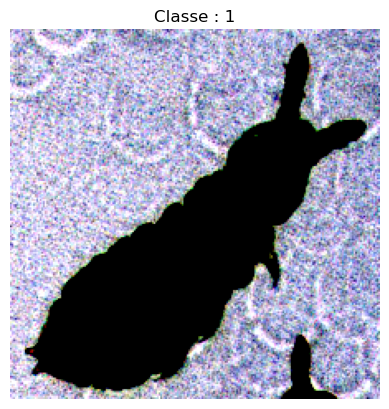

In [33]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Classe : {label}")
plt.axis('off')
plt.show()

In [34]:
import torch.nn.functional as F
import cv2

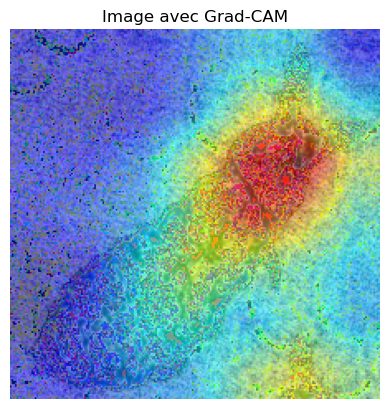

In [35]:
from captum.attr import LayerGradCam
from torchvision import models


image = image.to(DEVICE)
image = image.unsqueeze(0)

# Appliquer Grad-CAM
last_conv_layer = model.features[8][0]
layer_gc = LayerGradCam(model, last_conv_layer)  # Choisir la dernière couche convolutive

# Calculer les attributions Grad-CAM
attributions_gc = layer_gc.attribute(image, target=label)

height, width = image.shape[2], image.shape[3]

# Redimensionner la carte de chaleur (gradients) à la taille de l'image
attributions_gc = attributions_gc.squeeze().cpu().detach().numpy()
attributions_gc_resized = F.interpolate(torch.tensor(attributions_gc).unsqueeze(0).unsqueeze(0), 
                                        size=(height, width), mode='bilinear', align_corners=False).squeeze().numpy()

attributions_gc_resized = np.maximum(attributions_gc_resized, 0)  # Éviter les valeurs négatives
attributions_gc_resized = attributions_gc_resized / np.max(attributions_gc_resized)  # Normalisation

# Charger l'image d'origine pour superposition
image = image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)  # Convertir [C, H, W] à [H, W, C]

# Convertir l'image à l'échelle de 0-255 pour l'affichage
image = (image * 255).astype(np.uint8)
attributions_gc_resized = 1 - attributions_gc_resized
# Appliquer la carte de chaleur avec une certaine opacité (alpha)
heatmap = cv2.applyColorMap(np.uint8(255 * attributions_gc_resized), cv2.COLORMAP_JET)

# Appliquer de l'opacité (alpha blending)
alpha = 0.5  # Contrôle l'opacité de la carte de chaleur (0: complètement transparent, 1: complètement opaque)
superposed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

# Afficher l'image superposée
plt.imshow(superposed_image)
plt.title("Image avec Grad-CAM")
plt.axis('off')  # Enlever les axes
plt.show()


In [186]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import torch
import torch.nn.functional as F

image = image.permute(1, 2, 0).cpu().detach().numpy() 

# Fonction de prédiction pour LIME
def predict_fn(images):
    # Convertir les images en tensors PyTorch
    images_tensor = torch.tensor(images).float().to(DEVICE)  # Déplacer l'image sur le bon appareil (GPU ou CPU)
    images_tensor = images_tensor.permute(0, 3, 1, 2)  # Changer l'ordre des dimensions pour PyTorch [B, C, H, W]

    # Prédictions (logits)
    with torch.no_grad():
        output = model(images_tensor)
    
    # Convertir les logits en probabilités
    probabilities = F.softmax(output, dim=1).cpu().numpy()  # Appliquer softmax pour obtenir des probabilités
    return probabilities

# Initialiser le modèle d'explicabilité LIME
explainer = lime_image.LimeImageExplainer()

# Créer une explication
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=10000, num_features=100)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [187]:
explanation.top_labels

[6, 0, 1, 7, 8]

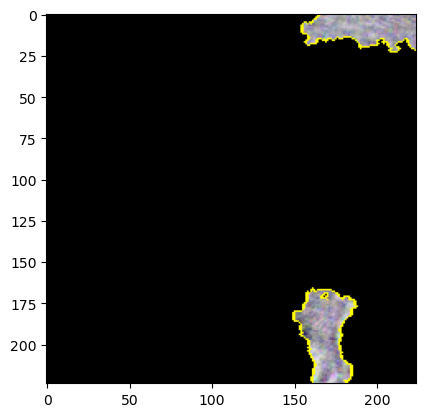

In [191]:
# Visualiser les explications
temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

## Predict

In [49]:
import csv
import torch.nn.functional as F

results = []

# Assurer que le modèle est en mode évaluation
model.eval()

# Désactiver la mise à jour des gradients
with torch.no_grad():
    for idx, (inputs, image_names) in enumerate(tqdm(test_loader, desc="Testing")):
        inputs = inputs.to(DEVICE)

        # Prédictions du modèle
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        #probas_matis = F.softmax(outputs, dim=1)

        # Ajouter au résultat (nom de l'image sans extension et la classe prédite)
        for i in range(len(inputs)):
            # On s'assure que le nom de l'image est correctement formaté sans tuple
            image_name = image_names[i]  # Récupérer le nom du fichier de l'image

            # Ajouter les résultats
            predicted_class = predict[i].item()
            results.append([image_name, predicted_class])

# Sauvegarder les résultats dans un fichier CSV
csv_output_path = './submit/efficientnet_label_predict.csv'
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['idx', 'gt'])  # Écrire l'en-tête
    writer.writerows(results)  # Écrire les lignes des résultats

print(f"Fichier CSV de soumission sauvegardé sous {csv_output_path}")


Testing: 100%|██████████| 1344/1344 [00:31<00:00, 42.71it/s]

Fichier CSV de soumission sauvegardé sous ./submit/efficientnet_label_predict.csv
